In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Load data
base_url = "https://raw.githubusercontent.com/freiraum-bq/Music_Project/main/"
df_art = pd.read_csv(base_url + "neo4j_artists.csv")
df_orig = pd.read_csv(base_url + "originals.csv")
df_cov = pd.read_csv(base_url + "covers.csv")
df_rel = pd.read_csv(base_url + "releases.csv")


In [65]:

# Build full graph
G = nx.DiGraph()

# Add artist nodes
for _, row in df_art.iterrows():
    G.add_node(row['artist_id'], label=row['common_name'], type='Artist')


# Add original song nodes and edges
for _, row in df_orig.iterrows():
    G.add_node(row['perf_id'], label=row['song_title'], type='Original')
    G.add_edge(row['perf_id'], row['org_art_id'], label='ORIGINAL_PERFORMED_BY')
    if pd.notna(row['release_id']):
        G.add_edge(row['perf_id'], row['release_id'], label='APPEARS_ON')

# Add cover song nodes and edges
for _, row in df_cov.iterrows():
    G.add_node(row['perf_id'], label=row['song_title'], type='Cover')
    G.add_edge(row['perf_id'], row['cov_art_id'], label='COVERED_BY')
    G.add_edge(row['perf_id'], row['cov_art_id'], label='RELEASED_BY')
    G.add_edge(row['perf_id'], row['org_perf_id'], label='IS_COVER_OF')

# Add release nodes (not needed in subgraph but created in full graph)
for _, row in df_rel.iterrows():
    G.add_node(row['release_id'], label=row['release_title'], type='Release')
    if pd.notna(row['artist_id']):
        G.add_edge(row['release_id'], row['artist_id'], label='RELEASED_BY')
    if isinstance(row['perf_ids'], str):
        for pid in row['perf_ids'].split(','):
            G.add_edge(pid.strip(), row['release_id'], label='APPEARS_ON')



In [ ]:

import random

# Sample 100 edges randomly
sample_edges = random.sample(list(G.edges), 100)

# Get nodes involved in these edges
nodes_in_edges = set()
for u, v in sample_edges:
    nodes_in_edges.add(u)
    nodes_in_edges.add(v)

# Build subgraph with these nodes and edges among them
G_small = G.subgraph(nodes_in_edges).copy()

print(f"Number of edges in G_small: {G_small.number_of_nodes()}")

# Node colors
color_map = {'Artist': 'red','Original': 'skyblue', 'Cover': 'lightgreen', 'Release': 'yellow'}
node_colors = [color_map.get(G_small.nodes[n].get('type', 'gray'), 'gray') for n in G_small.nodes]



Number of edges in G_small: 200


In [67]:
from pyvis.network import Network
import networkx as nx

# --- Assume you already have this graph ---
# G_small = your NetworkX graph
# pos = layout positions (not needed in PyVis)
# node_colors = list of color values per node (e.g. ["red", "blue", ...])

# 1. Initialize PyVis
net = Network(height="750px", width="100%", notebook=True, cdn_resources="in_line")

# 2. Manually add nodes with labels and colors
for node in G_small.nodes():
    label = G_small.nodes[node].get("label", str(node))
    color = node_colors[list(G_small.nodes).index(node)]  # map color by index
    net.add_node(n_id=node, label=label, color=color)

# 3. Add edges with labels (if any)
for source, target, data in G_small.edges(data=True):
    label = data.get("label", "")
    net.add_edge(source, target, label=label)

# 4. Show
net.show("graph.html")


graph.html


In [42]:
from collections import Counter

types = [d.get('type') for n, d in G_small.nodes(data=True)]
print(Counter(types))

Counter({'Release': 77, None: 68, 'Cover': 37, 'Original': 18})


In [27]:
from pyvis.network import Network
import networkx as nx

G = nx.karate_club_graph()
nt = Network(notebook=True, height='750px', width='100%', cdn_resources='in_line')  # or 'remote'
nt.from_nx(G)
nt.show("graph.html")

graph.html


In [28]:

# Visualize filtered graph
plt.figure(figsize=(12, 9))
# pos = nx.circular_layout(G_small)

pos = nx.spring_layout(G_small, seed=42, iterations=20) # 1.10 GiB
# pos = nx.kamada_kawai_layout(G_small)  #646. GiB



<Figure size 1200x900 with 0 Axes>

In [20]:

# Node colors
color_map = {'Original': 'skyblue', 'Cover': 'lightgreen'}
node_colors = [color_map.get(G_small.nodes[n].get('type', 'gray'), 'gray') for n in G_small.nodes]


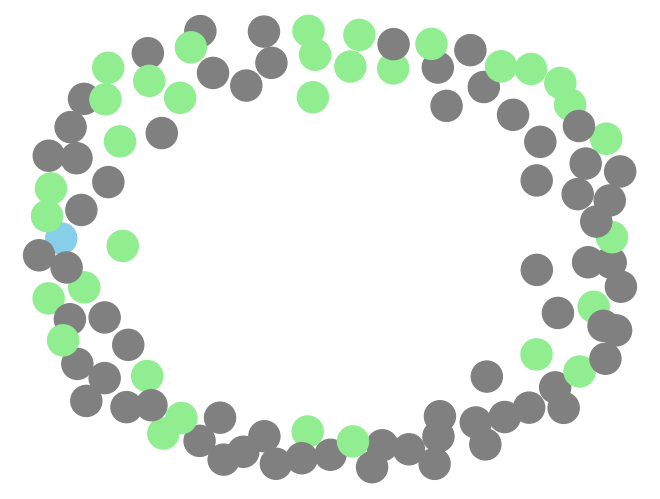

In [21]:
# Draw
nx.draw(G_small, pos, with_labels=False, node_color=node_colors, node_size=500, edge_color='gray')


In [7]:
nx.draw_networkx_labels(G_small, pos, labels={n: G_small.nodes[n]['label'] for n in G_small.nodes}, font_size=7)


KeyError: 'label'

In [ ]:

nx.draw_networkx_edge_labels(G_small, pos, edge_labels=nx.get_edge_attributes(G_small, 'label'), font_size=6)

In [ ]:

plt.title("Filtered Music Graph: Only Originals & Covers")
plt.axis('off')
plt.tight_layout()
plt.show()
